In [1]:
# Set CUDA_LAUNCH_BLOCKING for detailed debugging
%env CUDA_LAUNCH_BLOCKING=1

import torch
import torch.nn as nn
import pandas as pd
from transformers import DebertaV2Tokenizer, DebertaV2Model
from torchvision import models, transforms
from PIL import Image
import os
from sklearn.metrics import f1_score, accuracy_score, classification_report
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load and preprocess dataset
data = pd.read_csv("/kaggle/input/tweet-data-game-on/Updated_Tweet_Data.csv")  # Adjust path to your dataset
data = data[data['Content'] != "Error: Tweet could not be scraped"]
data = data.dropna(subset=['Content']).reset_index(drop=True)

# Initialize DeBERTaV3 Tokenizer and Image Transformations
tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-large")
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define Text Encoder (DeBERTaV3 Large)
class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.deberta = DebertaV2Model.from_pretrained("microsoft/deberta-v3-large")
        self.proj = nn.Linear(1024, 512)  # Project DeBERTaV3 output to 512-dim

    def forward(self, input_ids, attention_mask):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        return self.proj(outputs[:, 0, :])  # Use [CLS] token for text representation

# Define Minimal Image Encoder (DenseNet-121)
class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        densenet = models.densenet121(pretrained=True)
        self.features = densenet.features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.proj = nn.Linear(1024, 512)  # Reduce image focus with DenseNet-121 and project to 512-dim

    def forward(self, images):
        features = self.features(images)
        pooled = self.avgpool(features).view(features.size(0), -1)
        return self.proj(pooled)  # Project to 512-dim

# Define Multimodal Model with Transformer Encoder for Fusion
class MultimodalTransformerModel(nn.Module):
    def __init__(self, hidden_dim=512, output_dim=4):
        super(MultimodalTransformerModel, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)
        self.classifier = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text_features, image_features):
        combined_features = torch.stack([text_features, image_features], dim=1)
        fused_features = self.transformer_encoder(combined_features).mean(dim=1)
        return self.classifier(fused_features)

# Preprocessing functions
def preprocess_text(text):
    encoding = tokenizer(text, padding="max_length", max_length=128, truncation=True, return_tensors="pt")
    return encoding["input_ids"].squeeze(0), encoding["attention_mask"].squeeze(0)

def preprocess_image(image_name):
    if pd.isna(image_name) or not isinstance(image_name, str):
        return torch.zeros(3, 224, 224)
    image_path = os.path.join("/kaggle/input/tweet-data-game-on/Tweet_Images/", image_name)  # Update path accordingly
    try:
        image = Image.open(image_path).convert("RGB")
        return image_transform(image)
    except FileNotFoundError:
        return torch.zeros(3, 224, 224)

# Dataset and Dataloader
class EvalitaDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text_input, attention_mask = preprocess_text(row["Content"])
        image_input = preprocess_image(row.get("Image_Name", None))
        label = torch.tensor(row["Label"], dtype=torch.long)
        return {'input_ids': text_input, 'attention_mask': attention_mask, 'pixel_values': image_input}, label
    
    def __len__(self):
        return len(self.data)

# Custom collate function
def collate_fn(batch):
    inputs, labels = zip(*batch)
    pixel_values = torch.stack([item['pixel_values'] for item in inputs])
    input_ids = pad_sequence([item['input_ids'] for item in inputs], batch_first=True)
    attention_mask = pad_sequence([item['attention_mask'] for item in inputs], batch_first=True)
    labels = torch.stack(labels)
    return {'pixel_values': pixel_values, 'input_ids': input_ids, 'attention_mask': attention_mask}, labels

dataset = EvalitaDataset(data)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

# Initialize Models, Optimizer, and Loss
text_encoder = TextEncoder().to(device)
image_encoder = ImageEncoder().to(device)
model = MultimodalTransformerModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# Training loop with metrics tracking
history = {'epoch': [], 'accuracy': [], 'f1_score': []}
for epoch in range(100):  # Increase epochs to achieve stable results
    model.train()
    total_loss, correct_predictions, total_samples = 0, 0, 0
    all_preds, all_labels = [], []
    
    for batch in dataloader:
        inputs, labels = batch
        input_ids, attention_mask, pixel_values = [inputs[key].to(device) for key in ['input_ids', 'attention_mask', 'pixel_values']]
        labels = labels.to(device)
        
        text_features = text_encoder(input_ids, attention_mask)
        image_features = image_encoder(pixel_values)
        
        outputs = model(text_features, image_features)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples
    f1 = f1_score(all_labels, all_preds, average="weighted")
    
    scheduler.step(f1)
    
    history['epoch'].append(epoch + 1)
    history['accuracy'].append(accuracy)
    history['f1_score'].append(f1)
    
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f} | F1 Score: {f1:.4f}")

# Convert history to DataFrame for analysis
history_df = pd.DataFrame(history)
print("\nTraining History:")
print(history_df)

env: CUDA_LAUNCH_BLOCKING=1
Using device: cuda


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 165MB/s]
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.se

Epoch 1 | Loss: 1.3546 | Accuracy: 0.3811 | F1 Score: 0.2820
Epoch 2 | Loss: 1.3279 | Accuracy: 0.3907 | F1 Score: 0.2921
Epoch 3 | Loss: 1.3129 | Accuracy: 0.3962 | F1 Score: 0.2670
Epoch 4 | Loss: 1.3082 | Accuracy: 0.3798 | F1 Score: 0.3002
Epoch 5 | Loss: 1.2983 | Accuracy: 0.3989 | F1 Score: 0.2963
Epoch 6 | Loss: 1.2924 | Accuracy: 0.3811 | F1 Score: 0.3055
Epoch 7 | Loss: 1.2742 | Accuracy: 0.4003 | F1 Score: 0.2929
Epoch 8 | Loss: 1.2697 | Accuracy: 0.3921 | F1 Score: 0.3136
Epoch 9 | Loss: 1.2504 | Accuracy: 0.4180 | F1 Score: 0.3267
Epoch 10 | Loss: 1.2429 | Accuracy: 0.4153 | F1 Score: 0.3148
Epoch 11 | Loss: 1.2462 | Accuracy: 0.4139 | F1 Score: 0.3480
Epoch 12 | Loss: 1.2169 | Accuracy: 0.4344 | F1 Score: 0.3713
Epoch 13 | Loss: 1.2044 | Accuracy: 0.4399 | F1 Score: 0.3782
Epoch 14 | Loss: 1.2010 | Accuracy: 0.4358 | F1 Score: 0.3731
Epoch 15 | Loss: 1.1851 | Accuracy: 0.4631 | F1 Score: 0.4141
Epoch 16 | Loss: 1.1694 | Accuracy: 0.4481 | F1 Score: 0.4045
Epoch 17 | Loss: 

In [3]:
# Save training history as a CSV file
history_df.to_csv("result.csv", index=False)
print("Training history saved as result.csv")

Training history saved as result.csv


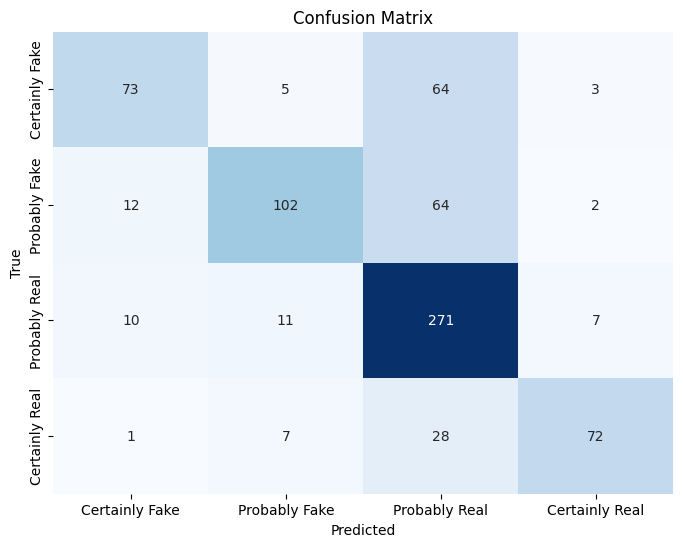


Errors by Class:
                Total Errors
Probably Fake             78
Certainly Fake            72
Certainly Real            36
Probably Real             28


In [9]:
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Detailed error breakdown by examining where the model misclassifies the most
errors = pd.DataFrame(conf_matrix, index=classes, columns=classes)
errors['Total Errors'] = errors.sum(axis=1) - np.diag(errors)
print("\nErrors by Class:")
print(errors[['Total Errors']].sort_values(by='Total Errors', ascending=False))

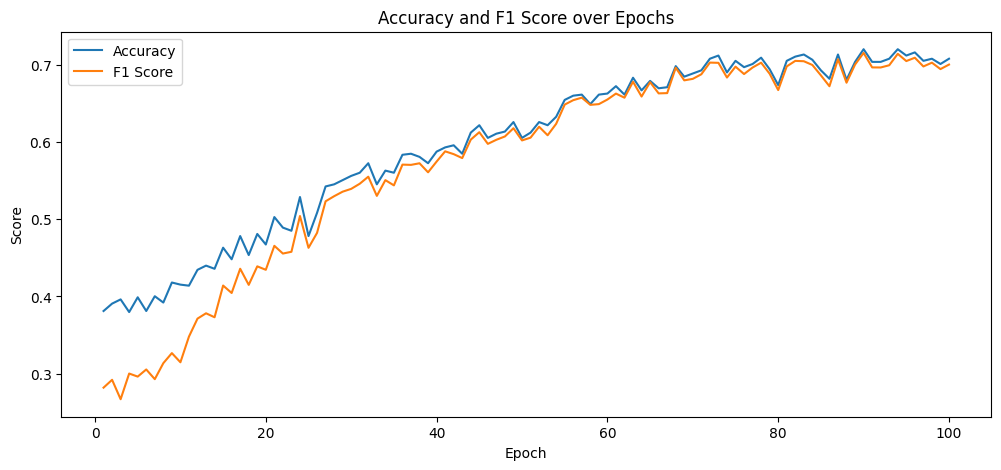

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Plot Accuracy and F1 Score over Epochs
plt.figure(figsize=(12, 5))
plt.plot(history_df['epoch'], history_df['accuracy'], label="Accuracy")
plt.plot(history_df['epoch'], history_df['f1_score'], label="F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Accuracy and F1 Score over Epochs")
plt.legend()
plt.show()

                precision    recall  f1-score    support
Certainly Fake   0.760417  0.503448  0.605809  145.00000
Probably Fake    0.816000  0.566667  0.668852  180.00000
Probably Real    0.634660  0.906355  0.746556  299.00000
Certainly Real   0.857143  0.666667  0.750000  108.00000
accuracy         0.707650  0.707650  0.707650    0.70765
macro avg        0.767055  0.660784  0.692805  732.00000
weighted avg     0.736988  0.707650  0.700077  732.00000


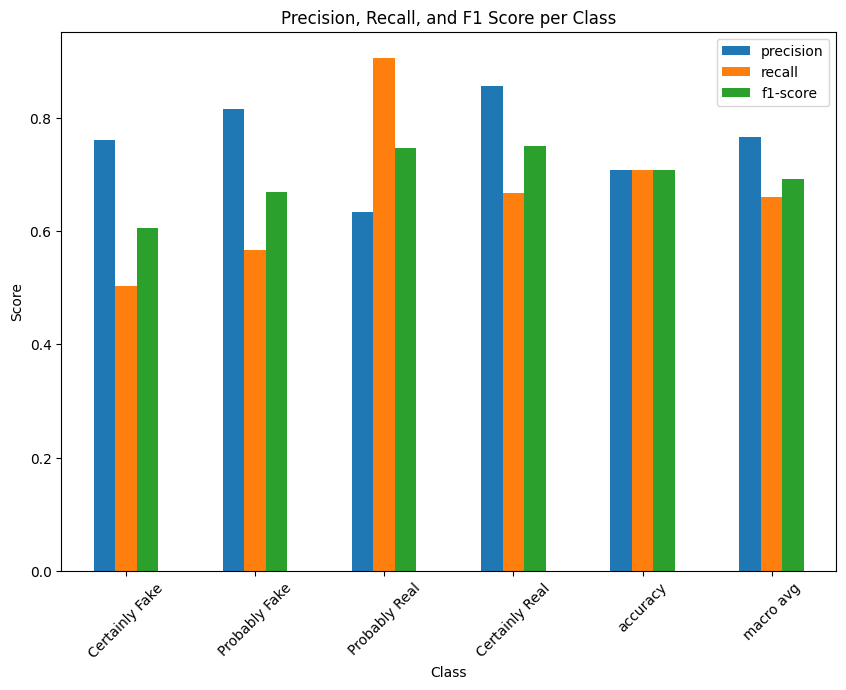

In [7]:
from sklearn.metrics import classification_report

# Assuming `all_labels` and `all_preds` contain labels and predictions for the last epoch
report = classification_report(all_labels, all_preds, target_names=["Certainly Fake", "Probably Fake", "Probably Real", "Certainly Real"], output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

# Plot Precision, Recall, and F1 Score per Class
metrics = report_df[['precision', 'recall', 'f1-score']].iloc[:-1]  # Exclude support and accuracy row
metrics.plot(kind='bar', figsize=(10, 7))
plt.title("Precision, Recall, and F1 Score per Class")
plt.ylabel("Score")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()


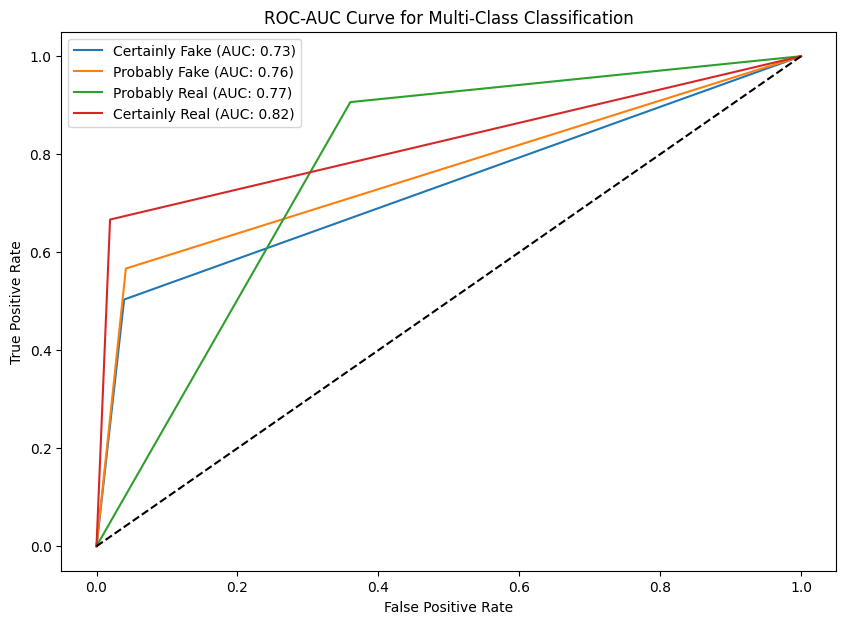

In [8]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Binarize the labels for each class
classes = ["Certainly Fake", "Probably Fake", "Probably Real", "Certainly Real"]
y_true = label_binarize(all_labels, classes=[0, 1, 2, 3])
y_scores = label_binarize(all_preds, classes=[0, 1, 2, 3])

plt.figure(figsize=(10, 7))

for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
    plt.plot(fpr, tpr, label=f'{class_name} (AUC: {roc_auc_score(y_true[:, i], y_scores[:, i]):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Multi-Class Classification")
plt.legend()
plt.show()
